In [1]:
#!/usr/bin/env python
# coding: utf-8

# python ./pivector.py --env=cenp --gamma=0.997 --noise=0.7 --seed=123

# In[1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import random
import os
import os.path
import argparse
import sys

import gym
gym.logger.set_level(40) # remove gym warning about float32 bound box precision

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt


# In[2]:


import common.env_lib
from common.env_utils import sorl_plot
from common.rl_lib import ReplayBuffer, OUNoise, ENoise, ValueNetwork, PolicyNetwork, ddpg_update, calc_values_of_states


# # In[3]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--env", default="csense", type=str, help="Environment. Specified in ./common/env_lib.py")
# parser.add_argument("--gamma", default=0.996, type=float, help="Discount Factor")
# parser.add_argument("--noise", default=0.8, type=float, help="Action Noise")
# parser.add_argument("--seed", default=238, type=int, help="Set seed [default: 238]")


# args = parser.parse_args()


# # arguments
# seed      = args.seed
# env_name  = args.env
# GAMMA     = args.gamma
# max_noise = args.noise
# pref      = args.pref

seed      = 954
env_name  = "cenp"
GAMMA     = 0.997
max_noise = 0.7/2
intrp_no  = 4 # no. of actions to interpolate to including greedy actions

# In[4]:


# set seed
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# In[5]:

################################################################################
# If using GPU
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

################################################################################
# Reward is now a tuple, not a scalar
class morlWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super(morlWrapper, self).__init__(env)
    
    def reward(self,action): # reward based on utility
            if action < 0:
                sense_reward = 0
                enp_reward = 0

            else:
                sense_dc = self.action2sensedc(action)
                sense_reward = min(1.0,sense_dc/self.req_obs)

                batt_threshold = 0.8
                if self.menergy_obs > batt_threshold:
                    enp_reward = 1
                else:
                    enp_reward = (self.menergy_obs - self.MIN_BATT)/(batt_threshold-self.MIN_BATT)

            self.sense_reward_log.append(sense_reward)
            self.enp_reward_log.append(enp_reward)
            return (sense_reward, enp_reward)
################################################################################
# Setting up environment base
experiment = "pimorl_g" + str(GAMMA) + "-n" + str(max_noise) + "-random_pref" + "-intrp" + str(intrp_no)
env = eval("common.env_lib." + env_name + "()")
env = morlWrapper(env)

################################################################################
# Setup Neural Networks

state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_dim = 256

value_lr  = 1e-3
policy_lr = 1e-4

SOFT_TAU=1e-2

batch_size  = 128
replay_buffer_size = 1000000
sense_replay_buffer = ReplayBuffer(replay_buffer_size)
enp_replay_buffer = ReplayBuffer(replay_buffer_size)

# Make model
sense_policy_net        = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
enp_policy_net          = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_sense_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_enp_policy_net   = PolicyNetwork(state_dim, action_dim, hidden_dim, device).to(device)

sense_value_net        = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
enp_value_net          = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_sense_value_net = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)
target_enp_value_net   = ValueNetwork(state_dim, action_dim, hidden_dim, device).to(device)

sense_value_optimizer  = optim.Adam(sense_value_net.parameters(),  lr=value_lr)
sense_policy_optimizer = optim.Adam(sense_policy_net.parameters(), lr=policy_lr)

enp_value_optimizer  = optim.Adam(enp_value_net.parameters(),  lr=value_lr)
enp_policy_optimizer = optim.Adam(enp_policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()
################################################################################
# Setup experiment parameters
exp_train_log ={}

env_location = 'tokyo'
exp_train_log[env_location] = {}    


START_YEAR = 1995
NO_OF_YEARS = 10
timeslots_per_day = 24
REQ_TYPE = "random"
prediction_horizon = 10*timeslots_per_day
henergy_mean= 0.13904705134356052 # 10yr hmean for tokyo
################################################################################
# Set up tags/folders

# Tags
env_tag = env_name + '_t' + str(timeslots_per_day) + '_' + REQ_TYPE
model_tag = experiment +'-'+str(seed)

# experiment tag
# name of folder to save models and results
exp_tag = env_tag  + "-" + experiment 

# experiment+seed tag
# tensorboard tag / model filename
tag     = exp_tag + '-' + str(seed) 
print("TensorBoard TAG: ",tag)

# Folders
cur_folder = os.getcwd()
# Tensorboard Folder
writer_folder = os.path.join(cur_folder, 'runs', exp_tag, tag )
writer = SummaryWriter(log_dir=writer_folder)

# Folder to save models
model_folder = os.path.join(cur_folder,"models", exp_tag)
if not os.path.exists(model_folder):
    os.makedirs(model_folder) 

# Folder/file to save training results
train_results_folder = os.path.join(cur_folder,"results", exp_tag, "train")
if not os.path.exists(train_results_folder): 
        os.makedirs(train_results_folder) 
train_log_file = os.path.join(train_results_folder, tag + '-train.npy')    

# Folder/file to save test results
test_results_folder = os.path.join(cur_folder,"results", exp_tag, "test")
if not os.path.exists(test_results_folder): 
        os.makedirs(test_results_folder) 
test_log_file = os.path.join(test_results_folder, tag + '-test.npy')  

################################################################################
# Start setup        
episode = 0
frame_idx = 0
eval_states = None # will be populated with held-out states

# evaluate Q-values of random states
NO_OF_STATES_TO_EVALUATE = timeslots_per_day*20 # how many states to sample to evaluate
EVAL_FREQ = prediction_horizon # how often to evaluate

TensorBoard TAG:  cenp_t24_random-pimorl_g0.997-n0.35-random_pref-intrp4-954


In [2]:
env.set_env(env_location, 1995, timeslots_per_day, 
                REQ_TYPE, offset=timeslots_per_day/2,
                p_horizon=prediction_horizon,
                hmean=henergy_mean)
state = env.reset()

Year:	 1995
Avg. Supply: 	 0.12686208471286678
Avg. Request: 	 0.13562095324043835
Avg reward:	 0.8847583447339515
Downtimes:	 6


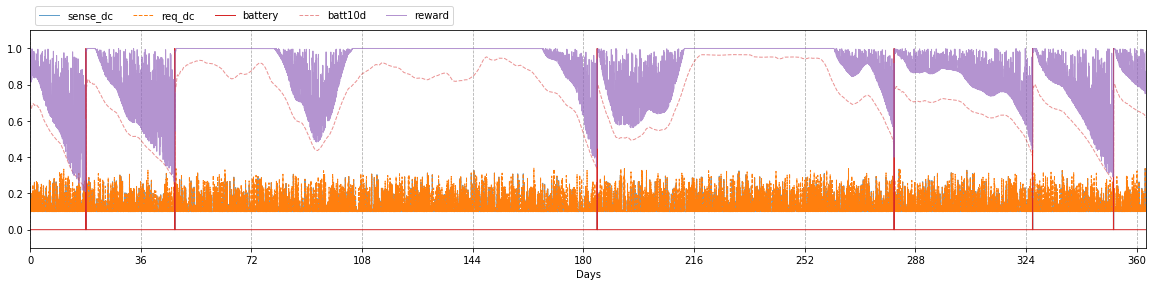

**********************************************************************

Year:	 1996
Avg. Supply: 	 0.13071786405556188
Avg. Request: 	 0.1366891933741102
Avg reward:	 0.9012669339231729
Downtimes:	 8


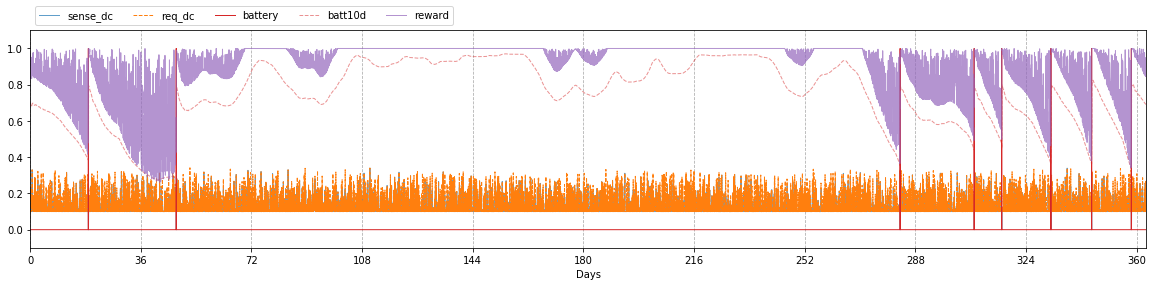

**********************************************************************

Year:	 1997
Avg. Supply: 	 0.13149018152757164
Avg. Request: 	 0.13692317552408315
Avg reward:	 0.9114608879904682
Downtimes:	 7


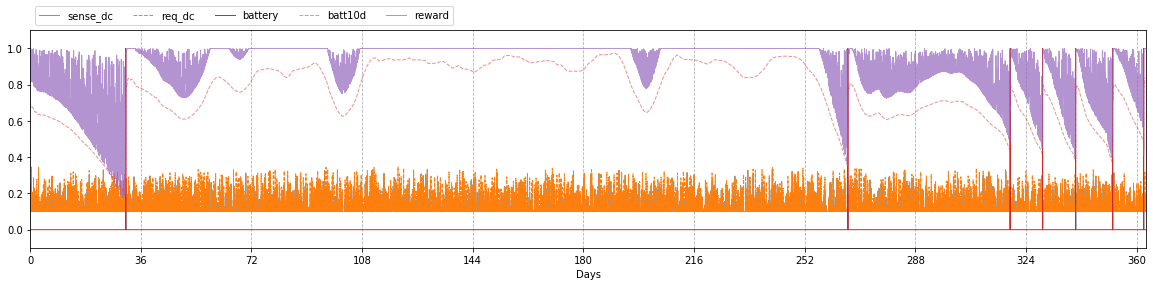

**********************************************************************

Year:	 1998
Avg. Supply: 	 0.11261616622902158
Avg. Request: 	 0.13162187164874936
Avg reward:	 0.8877006577843726
Downtimes:	 9


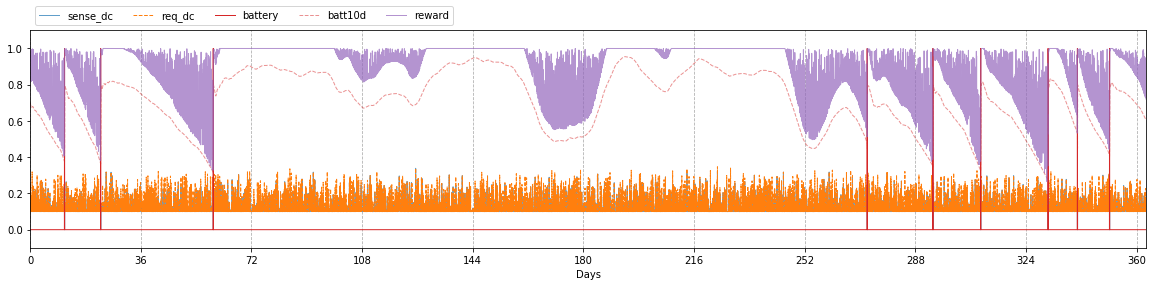

**********************************************************************

Year:	 1999
Avg. Supply: 	 0.12962781139399474
Avg. Request: 	 0.13638816390696434
Avg reward:	 0.8780047546283849
Downtimes:	 6


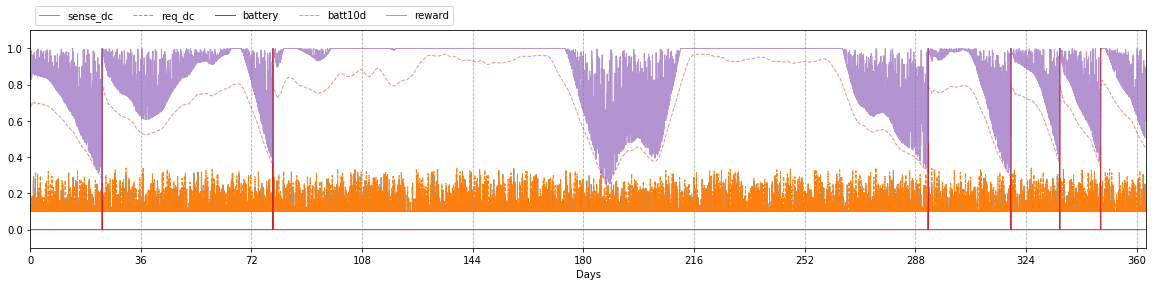

**********************************************************************

Year:	 2000
Avg. Supply: 	 0.13172691563247182
Avg. Request: 	 0.13699093869327497
Avg reward:	 0.9143266924534373
Downtimes:	 9


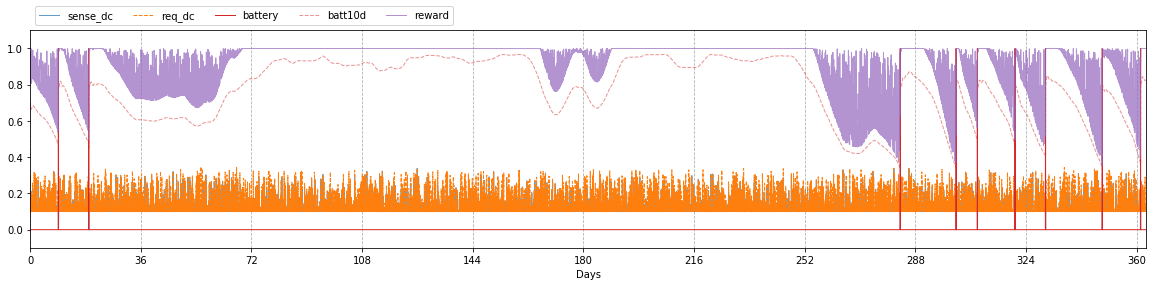

**********************************************************************

Year:	 2001
Avg. Supply: 	 0.1324805913917114
Avg. Request: 	 0.13720178232275052
Avg reward:	 0.9036291266470504
Downtimes:	 7


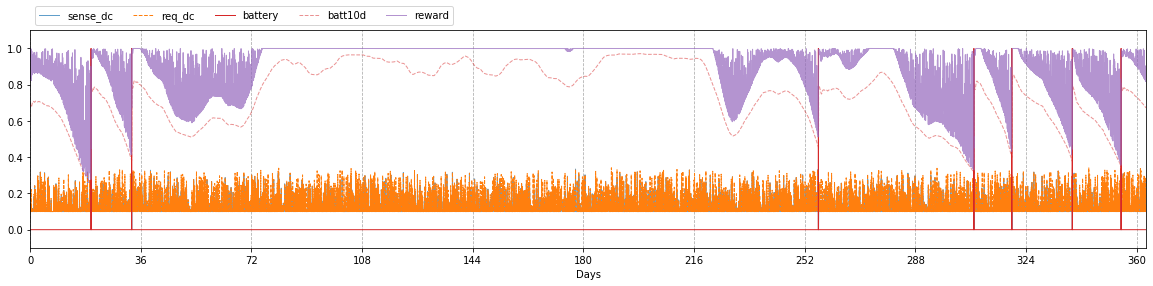

**********************************************************************

Year:	 2002
Avg. Supply: 	 0.13270122160063932
Avg. Request: 	 0.13726502189816725
Avg reward:	 0.9185011026637315
Downtimes:	 9


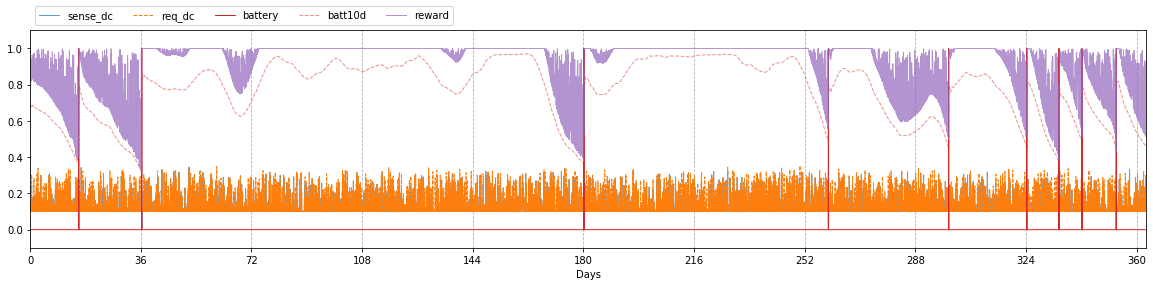

**********************************************************************

Year:	 2003
Avg. Supply: 	 0.1232175476652586
Avg. Request: 	 0.13460182624243608
Avg reward:	 0.8988286847371758
Downtimes:	 8


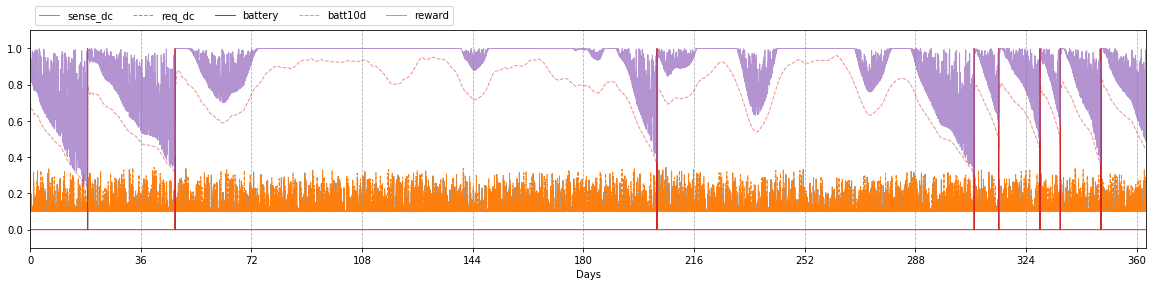

**********************************************************************

Year:	 2004
Avg. Supply: 	 0.14051605374017992
Avg. Request: 	 0.13945957510044973
Avg reward:	 0.9055239721976369
Downtimes:	 7


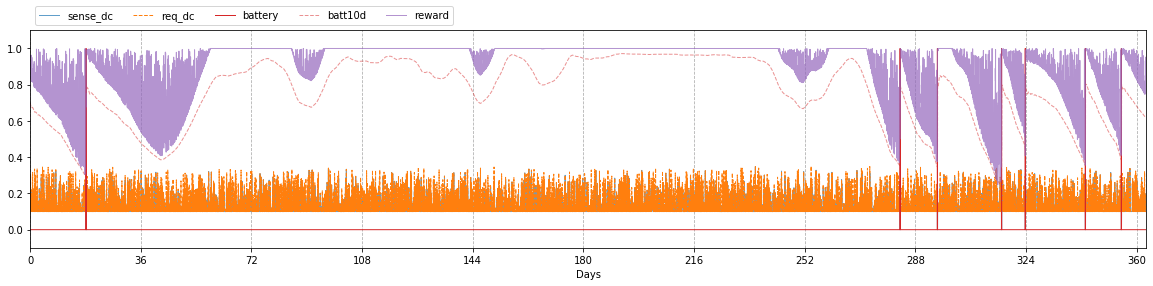

**********************************************************************



In [3]:
################################################################################
# Start training
for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
       
#     exp_noise = ENoise(env.action_space, 
#                        max_sigma=max_noise, 
#                        min_sigma=0.01, 
#                        decay_period=30*timeslots_per_day)
    
    env.set_env(env_location, year, timeslots_per_day, 
                REQ_TYPE, offset=timeslots_per_day/2,
                p_horizon=prediction_horizon,
                hmean=henergy_mean)
    state = env.reset()
    reward_rec = []
    ep_done_rec = []
    pref_rec = []
    episode_reward = 0
    done = False
    counter = 0 # record of number of steps in the environment. Required to keep a finite episode length

    while not done:
        pref = np.random.random(1)
        env.set_pref(pref)
        writer.add_scalar("Final/Preference", pref, frame_idx)
        if env.RECOVERY_MODE:
            no_action = 0            
            next_state, reward, done, _ = env.step(no_action)
            writer.add_scalar("iAction/intrp_dc[0]", no_action, frame_idx)
            writer.add_scalar("iAction/intrp_dc[1]", no_action, frame_idx)
            writer.add_scalar("iAction/intrp_dc[2]", no_action, frame_idx)
            writer.add_scalar("iAction/intrp_dc[3]", no_action, frame_idx)
            
            tot_reward = env.preference*reward[0] + (1-env.preference)*reward[1]
            reward_rec.append(tot_reward)
            writer.add_scalar("Reward/sense_reward", reward[0], frame_idx)        
            writer.add_scalar("Reward/enp_reward", reward[1], frame_idx)        
            writer.add_scalar("Reward/tot_reward", tot_reward, frame_idx)     

            ep_done = done or env.RECOVERY_MODE
            ep_done_rec.append(ep_done)
            state = next_state
            frame_idx +=1
            counter = 0

        else:
            with torch.no_grad():
                req_obs = state[-1] # request from server
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                # sense_model# sense_model: get action and q-value
                # convert action to DC
                sense_action_tensor = sense_policy_net(state_tensor)
                sense_value = sense_value_net(state_tensor, sense_action_tensor).cpu().item()
                raw_sense_action = sense_action_tensor.cpu().item()
                sense_action = (raw_sense_action*0.5 + 0.5)
                sense_dc = max(env.MIN_DC,sense_action*req_obs)

                # enp_model: get action and q-value
                # convert action to DC
                enp_action_tensor = enp_policy_net(state_tensor)
                enp_value = enp_value_net(state_tensor, enp_action_tensor).cpu().item()
                raw_enp_action = enp_action_tensor.cpu().item()
                enp_action = (raw_enp_action*0.5 + 0.5)
                enp_dc = max(env.MIN_DC,enp_action*req_obs)

            # Find two intermediate DC
            intrp_dc = np.linspace(start=min(sense_dc,enp_dc), 
                                   stop=max(sense_dc,enp_dc), 
                                   num=intrp_no)
#             intrp_dc_rec.append(intrp_dc)

            # Convert intrp_dc to action
            intrp_action_tensor = torch.FloatTensor(intrp_dc/req_obs).unsqueeze(1).to(device)
            batch_state_tensor = torch.FloatTensor([state]*len(intrp_dc)).to(device)

            # Get the q-values from sense and enp models for the intrp_dc
            intrp_sense_value = sense_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
            intrp_enp_value = enp_value_net(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
#             intrp_sense_value_rec.append(intrp_sense_value)
#             intrp_enp_value_rec.append(intrp_enp_value)

            # Calculate the node utility for all intrp_actions
            final_value = pref*intrp_sense_value + (1-pref)*intrp_enp_value
#             intrp_final_value_rec.append(final_value)

            # final_action is the action with the maximum final_value
            final_dc = intrp_dc[final_value.argmax()]
            final_action = final_dc/req_obs
            
            noisy_action = final_action + np.random.normal(loc=final_action, scale=max_noise)
            tr_action = np.clip(noisy_action,0,1)
            next_state, reward, done, _ = env.step(tr_action)
            
            writer.add_scalar("iAction/intrp_dc[0]", intrp_dc[0], frame_idx)
            writer.add_scalar("iAction/intrp_dc[1]", intrp_dc[1], frame_idx)
            writer.add_scalar("iAction/intrp_dc[2]", intrp_dc[2], frame_idx)
            writer.add_scalar("iAction/intrp_dc[3]", intrp_dc[3], frame_idx)
            
            writer.add_scalar("iAction_Value/Q-Value[0]", final_value[0], frame_idx)
            writer.add_scalar("iAction_Value/Q-Value[1]", final_value[1], frame_idx)
            writer.add_scalar("iAction_Value/Q-Value[2]", final_value[2], frame_idx)
            writer.add_scalar("iAction_Value/Q-Value[3]", final_value[3], frame_idx)
            
            writer.add_scalar("Final/Final Action", final_action, frame_idx)
            writer.add_scalar("Final/Final Action Value", max(final_value), frame_idx)
            
            tot_reward = env.preference*reward[0] + (1-env.preference)*reward[1]
            reward_rec.append(tot_reward)
            writer.add_scalar("Reward/sense_reward", reward[0], frame_idx)        
            writer.add_scalar("Reward/enp_reward", reward[1], frame_idx)        
            writer.add_scalar("Reward/tot_reward", tot_reward, frame_idx)        
            
            
            ep_done = done or env.RECOVERY_MODE or (counter==prediction_horizon-1)
            ep_done_rec.append(ep_done)

            # Convert action (0,1) --> nnaction(-1,1)
            raw_final_action = tr_action*2-1
            sense_replay_buffer.push(state, raw_final_action, reward[0], next_state, ep_done)
            enp_replay_buffer.push(state, raw_final_action, reward[1], next_state, ep_done)

            if len(sense_replay_buffer) > batch_size:
                ddpg_update(sense_value_net,
                            target_sense_value_net,
                            sense_policy_net,
                            target_sense_policy_net,
                            sense_value_optimizer,
                            sense_policy_optimizer,
                            value_criterion,
                            batch_size,
                            sense_replay_buffer,
                            device,
                            None,#writer
                            frame_idx,
                            gamma=GAMMA,
                            min_value=-np.inf,
                            max_value=np.inf,
                            soft_tau=1e-2,
                            policy_clipgrad=0.5,
                            value_clipgrad=0.5)
                
            if len(enp_replay_buffer) > batch_size:
                ddpg_update(enp_value_net,
                            target_enp_value_net,
                            enp_policy_net,
                            target_enp_policy_net,
                            enp_value_optimizer,
                            enp_policy_optimizer,
                            value_criterion,
                            batch_size,
                            enp_replay_buffer,
                            device,
                            writer,
                            frame_idx,
                            gamma=GAMMA,
                            min_value=-np.inf,
                            max_value=np.inf,
                            soft_tau=1e-2,
                            policy_clipgrad=0.5,
                            value_clipgrad=0.5)
                
            episode_reward += tot_reward
            frame_idx +=1
            counter +=1
            state = next_state
            
            if ep_done:
                writer.add_scalar("Episode_reward", episode_reward, episode)
                episode_reward = 0 # reset episode reward
                episode +=1 # increase episode count
                counter = 0 # reset episode counter

        
#         if len(replay_buffer) > 3*NO_OF_STATES_TO_EVALUATE and eval_states is None:
#             eval_states, eval_actions, _ ,_ , _ = replay_buffer.sample(NO_OF_STATES_TO_EVALUATE)
#             eval_states = torch.FloatTensor(eval_states).to(device)
#             eval_actions = torch.FloatTensor(eval_actions).unsqueeze(1).to(device)

#         if eval_states is not None and frame_idx % EVAL_FREQ == 0:
#             mean_val = calc_values_of_states(eval_states, eval_actions, value_net, device=device)
#             writer.add_scalar("values_mean", mean_val, frame_idx)
                
     # Log the traces and summarize results
    iteration_result={}

    # Saving traces
    iteration_result['reward_rec'] = np.array(reward_rec)
    iteration_result['ep_done_rec'] = np.array(ep_done_rec)
    iteration_result['action_log'] = np.array(env.action_log)
    iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
    iteration_result['env_log'] = np.array(env.env_log)
    iteration_result['eno_log'] = np.array(env.eno_log)
    iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
    iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

    
    # Summarizing results
    env_log = iteration_result['env_log']

    # Get henergy metrics
    henergy_rec = env_log[:,1]
    avg_henergy = henergy_rec.mean()
    iteration_result['avg_henergy'] = avg_henergy

    # Get req metrics
    req_rec = env_log[:,5]
    avg_req = req_rec.mean()            
    iteration_result['avg_req'] = avg_req

    # Get reward metrics
    # In this case, the reward metrics directly reflect the conformity
    reward_recx = iteration_result['reward_rec']
    # negative rewards = -1000 correspond to downtimes
    # To find average reward, remove negative values
    index = np.argwhere(reward_recx<0)
    rwd_recx = np.delete(reward_recx, index)
    avg_rwd = rwd_recx.mean()
    iteration_result['avg_rwd'] = avg_rwd

    # Get downtime metrics
    batt_rec = env_log[:,3]
    batt_rec[batt_rec>0.1]=0
    batt_rec[batt_rec!=0]=1
    downtimes = np.count_nonzero(batt_rec[:-1] < batt_rec[1:])
    iteration_result['downtimes'] = downtimes

    
    # Print summary
    print("Year:\t", year)            
    print("Avg. Supply: \t", avg_henergy)
    print("Avg. Request: \t", avg_req)
    print("Avg reward:\t", avg_rwd)
    print("Downtimes:\t", downtimes)
    
    # Plot traces
    sorl_plot(iteration_result, timeslots_per_day, START_DAY=0, NO_OF_DAY_TO_PLOT = 363)
    
    # Store results, traces and summary
    exp_train_log[env_location][year] = iteration_result
    print("*"*70)
    print("")

In [4]:
# In[11]:

# ################################################################################
# # Save Training Results in file
# np.save(train_log_file, exp_train_log)


# In[21]:

################################################################################
# display training performance metrics
train_log = exp_train_log[env_location]
print("\n\n***TRAINING PERFORMANCE****")
print("YEAR".ljust(6), "HMEAN".ljust(8), "REQ_MEAN".ljust(8), "AVG_DC".ljust(8), 
      "SNS_RWD".ljust(8), "ENP_RWD".ljust(8), "AVG_RWD".ljust(8), "DOWNTIMES".ljust(9))
for year in list(train_log.keys()):
    iteration_result =  train_log[year]
    # Print summarized metrics
    print(year, end=' ')
    sense_avg_rwd = iteration_result['sense_reward_log'].mean()
    enp_avg_rwd = iteration_result['enp_reward_log'].mean()
    average_rwd = iteration_result['avg_rwd']
    total_downtimes = iteration_result['downtimes']
    hmean = iteration_result['avg_henergy']
    reqmean = iteration_result['avg_req']
    sense_dc_mean = iteration_result['sense_dc_log'].mean()
    
    print(f'{hmean:7.3f}',end='  ')
    print(f'{reqmean:7.3f}',end='  ')
    print(f'{sense_dc_mean:7.3f}',end='  ')
    print(f'{sense_avg_rwd:7.3f}',end='  ')
    print(f'{enp_avg_rwd:7.3f}',end='  ')
    print(f'{average_rwd:7.3f}',end='  ')
    print(f'{total_downtimes:5d}',end='  ')
    print("")



***TRAINING PERFORMANCE****
YEAR   HMEAN    REQ_MEAN AVG_DC   SNS_RWD  ENP_RWD  AVG_RWD  DOWNTIMES
1995   0.127    0.136    0.126    0.963    0.830    0.885      6  
1996   0.131    0.137    0.125    0.964    0.854    0.901      8  
1997   0.131    0.137    0.125    0.967    0.870    0.911      7  
1998   0.113    0.132    0.122    0.963    0.831    0.888      9  
1999   0.130    0.136    0.125    0.961    0.816    0.878      6  
2000   0.132    0.137    0.125    0.967    0.874    0.914      9  
2001   0.132    0.137    0.125    0.966    0.858    0.904      7  
2002   0.133    0.137    0.127    0.970    0.880    0.919      9  
2003   0.123    0.135    0.126    0.967    0.848    0.899      8  
2004   0.141    0.139    0.127    0.965    0.859    0.906      7  


In [5]:
# # In[14]:

# ################################################################################
# # Save policy model weights with filename as tag
# model_file = os.path.join(model_folder, (tag + "-policy.pt"))
# torch.save(policy_net.state_dict(), model_file)


# # In[15]:

# ################################################################################
# # Save value model weights with filename as tag
# model_file = os.path.join(model_folder, (tag + "-value.pt"))
# torch.save(value_net.state_dict(), model_file)

# # In[16]:

In [6]:
# use testing module from morl_runtime code

In [7]:
# Make model

sense_pnet = sense_policy_net
enp_pnet   = enp_policy_net

sense_qnet = sense_value_net
enp_qnet   = enp_value_net


sense_pnet.eval()
sense_qnet.eval()
enp_pnet.eval()
enp_qnet.eval();

env_location_list = ['tokyo']
START_YEAR  = 1995
NO_OF_YEARS = 24


for pref in [0.2, 0.5, 0.8]:
    print("\n\nPreference: ", pref)

    exp_test_log = {} # dictionary to store test results
    for env_location in env_location_list:
    #     print(env_location)
        exp_test_log[env_location] = {}
        for year in range(START_YEAR, START_YEAR+NO_OF_YEARS):
            exp_test_log[env_location][year]={}

            env.set_env(env_location,year, timeslots_per_day, 
                        REQ_TYPE, offset=timeslots_per_day/2,
                        p_horizon=prediction_horizon,
                        hmean=henergy_mean)    
            state = env.reset()
            reward_rec = []

            intrp_dc_rec = []
            intrp_sense_value_rec = []
            intrp_enp_value_rec = []
            intrp_final_value_rec = []

            ep_done_rec = []
            done = False
            while not done:
                if env.RECOVERY_MODE:
                    no_action = 0            
                    next_state, reward, done, _ = env.step(no_action)       
                else:
                    with torch.no_grad():
                        req_obs = state[-1] # request from server
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

                        # sense_model# sense_model: get action and q-value
                        # convert action to DC
                        sense_action_tensor = sense_pnet(state_tensor)
                        sense_value = sense_qnet(state_tensor, sense_action_tensor).cpu().item()
                        raw_sense_action = sense_action_tensor.cpu().item()
                        sense_action = (raw_sense_action*0.5 + 0.5)
                        sense_dc = max(env.MIN_DC,sense_action*req_obs)

                        # enp_model: get action and q-value
                        # convert action to DC
                        enp_action_tensor = enp_pnet(state_tensor)
                        enp_value = enp_qnet(state_tensor, enp_action_tensor).cpu().item()
                        raw_enp_action = enp_action_tensor.cpu().item()
                        enp_action = (raw_enp_action*0.5 + 0.5)
                        enp_dc = max(env.MIN_DC,enp_action*req_obs)

                    # Find two intermediate DC
                    intrp_dc = np.linspace(start=min(sense_dc,enp_dc), 
                                           stop=max(sense_dc,enp_dc), 
                                           num=4)
                    intrp_dc_rec.append(intrp_dc)

                    # Convert intrp_dc to action
                    intrp_action_tensor = torch.FloatTensor(intrp_dc/req_obs).unsqueeze(1).to(device)
                    batch_state_tensor = torch.FloatTensor([state]*len(intrp_dc)).to(device)

                    # Get the q-values from sense and enp models for the intrp_dc
                    intrp_sense_value = sense_qnet(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
                    intrp_enp_value = enp_qnet(batch_state_tensor, intrp_action_tensor).cpu().detach().numpy().squeeze()
                    intrp_sense_value_rec.append(intrp_sense_value)
                    intrp_enp_value_rec.append(intrp_enp_value)

                    # Calculate the node utility for all intrp_actions
                    final_value = pref*intrp_sense_value + (1-pref)*intrp_enp_value
                    intrp_final_value_rec.append(final_value)

                    # final_action is the action with the maximum final_value
                    final_dc = intrp_dc[final_value.argmax()]
                    final_action = final_dc/req_obs

                    # Execute action
                    next_state, reward, done, _ = env.step(final_action)

                reward_rec.append(reward)
                ep_done = done or env.RECOVERY_MODE
                ep_done_rec.append(ep_done)
                state = next_state

            # Log the traces and summarize results
            iteration_result={}

            # Saving traces
            iteration_result['reward_rec'] = np.array(reward_rec)
            iteration_result['ep_done_rec'] = np.array(ep_done_rec)
            iteration_result['action_log'] = np.array(env.action_log)
            iteration_result['sense_dc_log'] = np.array(env.sense_dc_log)
            iteration_result['env_log'] = np.array(env.env_log)
            iteration_result['eno_log'] = np.array(env.eno_log)
            iteration_result['sense_reward_log'] = np.array(env.sense_reward_log)
            iteration_result['enp_reward_log'] = np.array(env.enp_reward_log)

            iteration_result['intrp_dc_rec'] = intrp_dc_rec
            iteration_result['intrp_sense_value_rec'] = intrp_sense_value_rec
            iteration_result['intrp_enp_value_rec'] = intrp_enp_value_rec
            iteration_result['intrp_final_value_rec'] = intrp_final_value_rec

            # Summarizing results
            env_log = iteration_result['env_log']

            # Get henergy metrics
            henergy_rec = env_log[:,1]
            avg_henergy = henergy_rec.mean()
            iteration_result['avg_henergy'] = avg_henergy

            # Get req metrics
            req_rec = env_log[:,5]
            avg_req = req_rec.mean()            
            iteration_result['avg_req'] = avg_req

            # Get reward metrics
            # In this case, the reward metrics directly reflect the conformity
            reward_rec = iteration_result['reward_rec']
            # negative rewards = -1000 correspond to downtimes
            # To find average reward, remove negative values
            index = np.argwhere(reward_rec<0)
            rwd_rec = np.delete(reward_rec, index)
            avg_rwd = rwd_rec.mean()
            iteration_result['avg_rwd'] = avg_rwd

            # Get downtime metrics
            ep_done_rec =  iteration_result['ep_done_rec']
            downtimes = np.count_nonzero(ep_done_rec[:-1] < ep_done_rec[1:]) - 1 # last env done is excluded
            iteration_result['downtimes'] = downtimes

    #         print("Year:\t", year)            
            exp_test_log[env_location][year] = iteration_result
    #     print("")


    # summarize metrics and display
    # print("\n\n***TEST RESULTS****")
    # print("Tag:", tag)
    # print("Seed:", seed)


    print("LOCATION".ljust(12), "YEAR".ljust(6), "HMEAN".ljust(8), "REQ_MEAN".ljust(8), "AVG_DC".ljust(8), 
          "SNS_RWD".ljust(8), "ENP_RWD".ljust(8), "AVG_RWD".ljust(8), "DOWNTIMES".ljust(9))

    exp_result = exp_test_log
    location_list = list(exp_result.keys())
    for location in location_list:
        yr_list = list(exp_result[location].keys())
        for year in yr_list:
            run_log = exp_result[location][year]
            # Print summarized metrics
            print(location.ljust(12), year, end=' ')
            sense_avg_rwd = run_log['sense_reward_log'].mean()
            enp_avg_rwd = run_log['enp_reward_log'].mean()

            average_rwd = run_log['avg_rwd']
            total_downtimes = run_log['downtimes']
            hmean = run_log['avg_henergy']
            reqmean = run_log['avg_req']
            sense_dc_mean = run_log['sense_dc_log'].mean()

            print(f'{hmean:7.3f}',end='  ')
            print(f'{reqmean:7.3f}',end='  ')
            print(f'{sense_dc_mean:7.3f}',end='  ')
            print(f'{sense_avg_rwd:7.3f}',end='  ')
            print(f'{enp_avg_rwd:7.3f}',end='  ')
            print(f'{average_rwd:7.3f}',end='  ')
            print(f'{total_downtimes:5d}',end='  ')
            print("")




Preference:  0.2
LOCATION     YEAR   HMEAN    REQ_MEAN AVG_DC   SNS_RWD  ENP_RWD  AVG_RWD  DOWNTIMES
tokyo        1995   0.127    0.136    0.102    0.960    0.935    0.955      0  
tokyo        1996   0.131    0.137    0.102    0.956    0.911    0.940      2  
tokyo        1997   0.131    0.137    0.102    0.960    0.931    0.953      2  
tokyo        1998   0.113    0.132    0.102    0.957    0.885    0.925      4  
tokyo        1999   0.130    0.136    0.102    0.960    0.934    0.954      1  
tokyo        2000   0.132    0.137    0.102    0.958    0.920    0.946      4  
tokyo        2001   0.132    0.137    0.102    0.958    0.920    0.946      2  
tokyo        2002   0.133    0.137    0.102    0.954    0.883    0.923      2  
tokyo        2003   0.123    0.135    0.102    0.959    0.909    0.938      2  
tokyo        2004   0.141    0.139    0.102    0.954    0.895    0.931      2  
tokyo        2005   0.133    0.137    0.102    0.955    0.883    0.924      1  
tokyo        2006